<a href="https://colab.research.google.com/github/Menager49/PY-net-elec/blob/main/Projet_Net_Elec_Equipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Net Elec

Promotion DA continue - Dec. 2021 
Membres de l'équipe : Christine, Pierre-Emmanuel, Cédric
Mentor : Pierre

# Partie 1 : Chargement et Preprocessing <a class="anchor" id="Partie01"><a>

## 1.1 Chargements modules et connexion Google Drive

In [6]:
# Montage du Drive à Colab pour hebergé le dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [74]:
%cd /content/drive/MyDrive/Github/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Github/'
/content


In [58]:
# Chargement des modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.dates import DateFormatter
import datetime as dt
import matplotlib.dates as mdates
import missingno as msno

In [2]:
print('Nombre de lignes sur 5 ans : ',365*5*24*2*12)

Nombre de lignes sur 5 ans :  1051200


## 1.2 PreProcessing : création du Dataset Date-Region

In [3]:
# Limites temporelles:
Date_debut = '01/01/2016'
Date_fin = '31/12/2021'

#Date_debut = '2016-01-01T00:00:00+01:00'
#Date_fin = '2021-12-31T00:00:00+01:00'


In [4]:
# Construction d'un DF structure de DF propre

# Génération d'un array de date
time = pd.date_range(start=Date_debut, end=Date_fin, freq='30min', tz='Europe/Paris') # Renvoi un Datetimeindex
time = np.array(time) # Transform from timeseries-index in numpy arrays

# Liste de région
region = ['Occitanie',
          'Normandie', 
          'Bretagne',
          "Provence-Alpes-Côte d'Azur", 
          'Hauts-de-France', 
          'Île-de-France',
          'Grand Est', 
          'Nouvelle-Aquitaine',
          'Bourgogne-Franche-Comté', 
          'Centre-Val de Loire',
          'Auvergne-Rhône-Alpes', 
          'Centre-Val de Loire']

# Construction d'une liste de tuple['Date','region_nom']
dateregion = []

for i in region:
    for j in time:
        dateregion.append([j,i])

# Conversion de la liste de Tuple en DataFrame:
dateregion = pd.DataFrame(dateregion, columns=['date','region_nom'])
dateregion.head(5)

,date,region_nom
0,2016-01-01 00:00:00+01:00,Occitanie
1,2016-01-01 00:30:00+01:00,Occitanie
2,2016-01-01 01:00:00+01:00,Occitanie
3,2016-01-01 01:30:00+01:00,Occitanie
4,2016-01-01 02:00:00+01:00,Occitanie


## 1.3 Preprocessing DataSet Energie

### 1.3.1 Chargement

In [33]:
df_energie = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/DataScientest_Projet Net Elec/eco2mix-regional-cons-def.csv', 
                 sep=';', 
                 parse_dates = {'Date_Heure': ['Date', 'Heure'] })

In [ ]:
#df_energie.head(5)

### 1.3.2 Filtrage

In [ ]:
#df_energie.info()

In [34]:
### Liste de varaibles à supprimer
col_to_drop = ['Column 26',
              'Code INSEE région',
              'Date_Heure'
              ]
### Suppression des varaibles inutiles
df_energie = df_energie.drop(col_to_drop, axis=1)

In [ ]:
# df_energie.info()

In [35]:
# Filtrage temporel

# Conversion du type pour le champs date
df_energie['Date - Heure'] = pd.to_datetime(df_energie['Date - Heure'], utc=True)

# Limites temporelles haute et basse
df_energie = df_energie[(df_energie['Date - Heure'] >= Date_debut) & (df_energie['Date - Heure'] <= Date_fin)]

### 1.3.3 Standardisation

In [36]:
# Les champs sont renommés : 
Dic_Noms = {
    'Région'             :'region_nom',
    'Nature'             :'nature',
    'Date - Heure'       :'date',
    'Consommation (MW)'  :'conso_inter',
    'Pompage (MW)'       :'conso_hydro',
    'Thermique (MW)'     :'prod_therm',
    'Nucléaire (MW)'     :'prod_nuc',
    'Solaire (MW)'       :'prod_sol',
    'Hydraulique (MW)'   :'prod_hydro',
    'Bioénergies (MW)'   :'prod_bio',
    'Eolien (MW)'        :'prod_eol',
    'Ech. physiques (MW)':'echanges',
    'TCO Thermique (%)'  :'tco_therm', 
    'TCO Nucléaire (%)'  :'tco_nuc',
    'TCO Eolien (%)'     :'tco_eol', 
    'TCO Solaire (%)'    :'tco_sol', 
    'TCO Hydraulique (%)':'tco_hydro',
    'TCO Bioénergies (%)':'tco_bio', 
    'TCH Nucléaire (%)'  :'tch_nuc', 
    'TCH Eolien (%)'     :'tch_eol',
    'TCH Thermique (%)'  :'tch_therm', 
    'TCH Solaire (%)'    :'tch_sol', 
    'TCH Hydraulique (%)':'tch_hydro', 
    'TCH Bioénergies (%)':'tch_bio', 
            }

df_energie = df_energie.rename(Dic_Noms, axis=1)

### 1.3.4 Complétude

#### **Doublons**

In [37]:
# Identification des lignes dupliquées
df_energie.duplicated().sum()

72

In [38]:
# Traitement des lignes dupliquées
df_energie = df_energie.drop_duplicates()
df_energie.duplicated().sum()

0

#### **NANs**

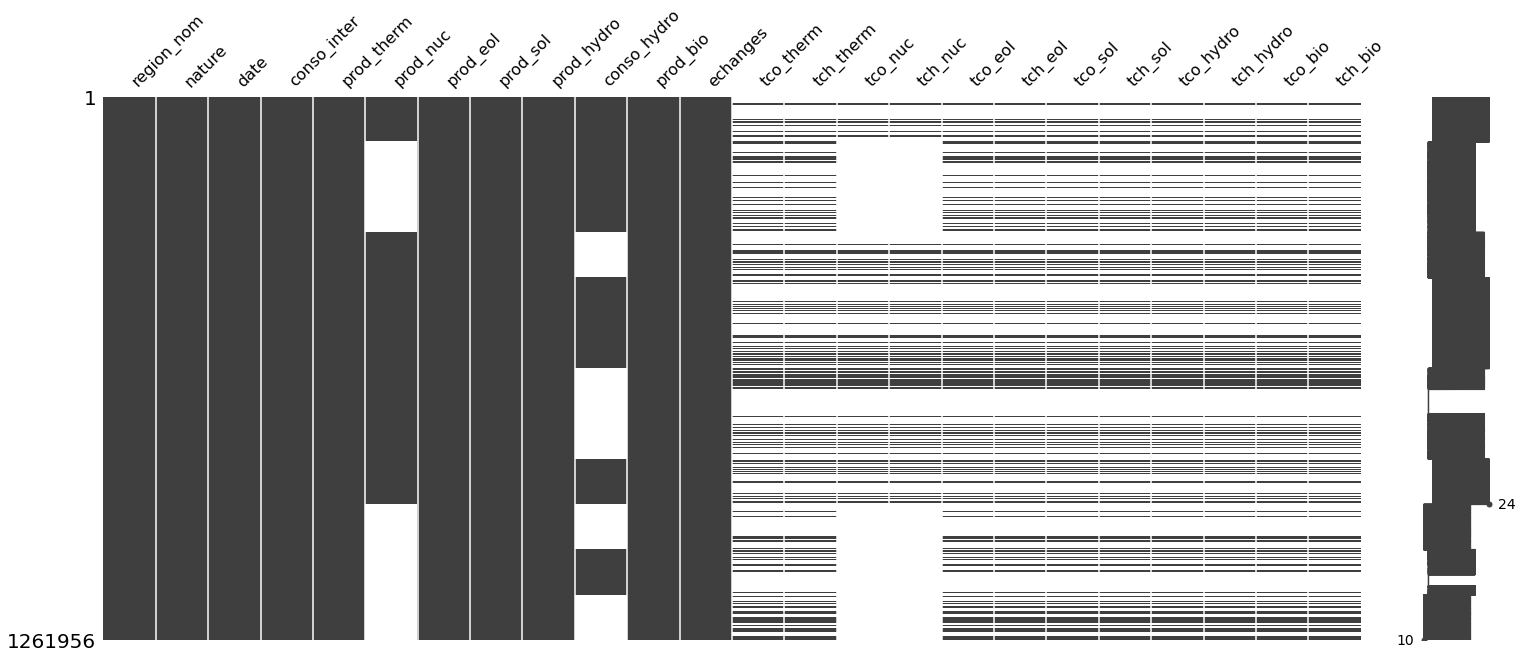

In [39]:
# Trie du DF par région
df_energie.sort_values(by=['region_nom'],inplace=True)

# Visualisation des NANs
msno.matrix(df_energie);

In [42]:
df_nuc_NAN = df_energie[df_energie['prod_nuc'].isnull()==True].groupby(['region_nom']).agg({'prod_nuc':'sum'})
df_nuc_NAN.head(6)

,prod_nuc
region_nom,
Bourgogne-Franche-Comté,0.0
Bretagne,0.0
Pays de la Loire,0.0
Provence-Alpes-Côte d'Azur,0.0
Île-de-France,0.0


In [43]:
df_nuc_VAL = df_energie[df_energie['prod_nuc'].isnull()==False].groupby(['region_nom']).agg({'prod_nuc':'sum'})
df_nuc_VAL.head(6)

,prod_nuc
region_nom,
Auvergne-Rhône-Alpes,963985940.0
Centre-Val de Loire,861552904.0
Grand Est,881484568.0
Hauts-de-France,383171739.0
Normandie,653323578.0
Nouvelle-Aquitaine,510262402.0


In [44]:
df_hydro_NAN = df_energie[df_energie['conso_hydro'].isnull()==True].groupby(['region_nom']).agg({'conso_hydro':'sum'})
df_hydro_NAN.head(12)

,conso_hydro
region_nom,
Centre-Val de Loire,0.0
Normandie,0.0
Nouvelle-Aquitaine,0.0
Pays de la Loire,0.0
Île-de-France,0.0


In [45]:
df_hydro_VAL = df_energie[df_energie['conso_hydro'].isnull()==False].groupby(['region_nom']).agg({'conso_hydro':'sum'})
df_hydro_VAL.head(12)

,conso_hydro
region_nom,
Auvergne-Rhône-Alpes,-46348906.0
Bourgogne-Franche-Comté,-447440.0
Bretagne,-757982.0
Grand Est,-9837371.0
Hauts-de-France,0.0
Occitanie,-21989815.0
Provence-Alpes-Côte d'Azur,-561004.0


In [46]:
# Cas 3 : Remplacement par zéro sur le champs nucléaire pour les région n'ayant pas de nucléaire
list_fillzero=['prod_nuc', 'conso_hydro']

for i in list_fillzero:
    df_energie[i].fillna(0, inplace=True)

del df_nuc_NAN
del df_nuc_VAL
del df_hydro_NAN 
del df_hydro_VAL 

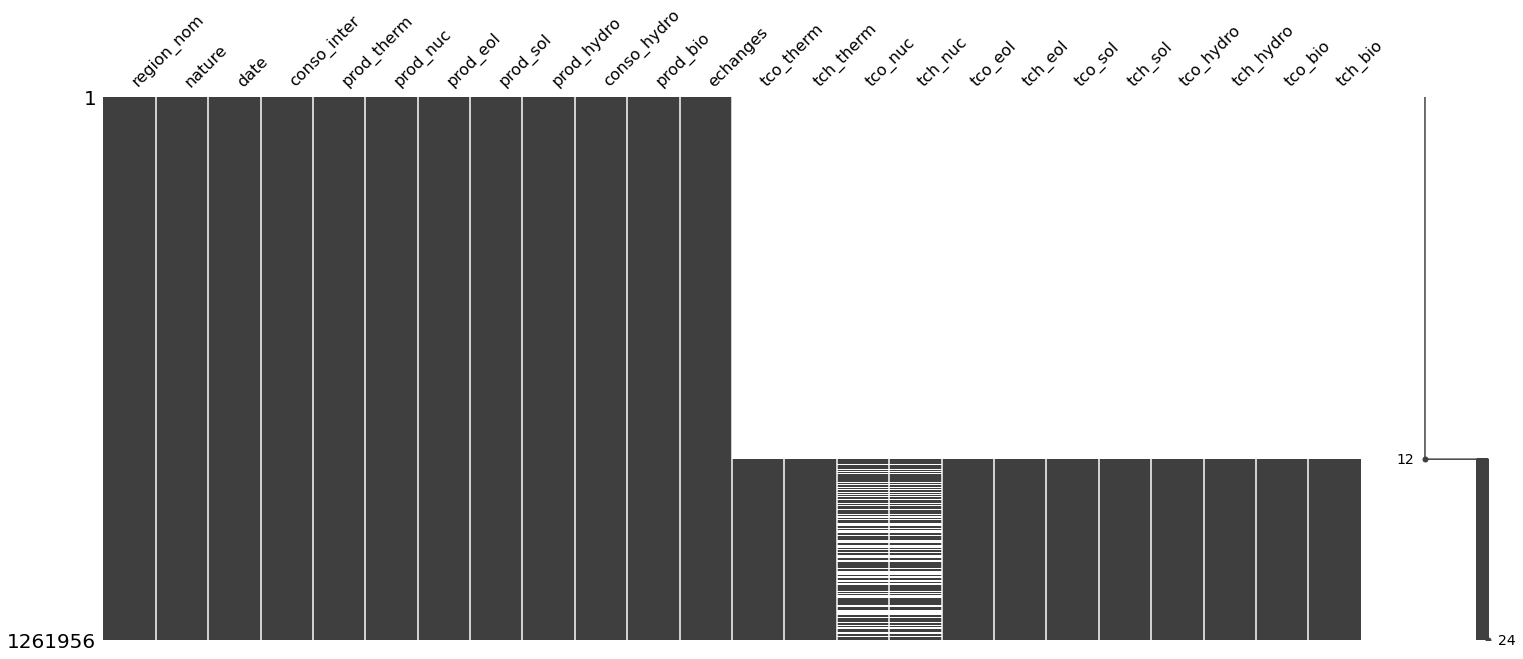

In [47]:
# Trie du DF par date
df_energie.sort_values(by=['date'],inplace=True)

# Visualisation des NANs
msno.matrix(df_energie);

In [52]:
df_tco_therm_NAN = df_energie[df_energie['tco_therm'].isnull()==True].groupby(pd.Grouper(key = 'date', freq = 'Y')).agg({'date':'count'})
df_tco_therm_NAN.head(24)

,date
date,
2016-12-31 00:00:00+00:00,210804
2017-12-31 00:00:00+00:00,210228
2018-12-31 00:00:00+00:00,210228
2019-12-31 00:00:00+00:00,210204


In [62]:
df_tco_therm_VAL = df_energie[df_energie['tco_therm'].isnull()==False].groupby(pd.Grouper(key = 'date', freq = 'Y')).agg({'date':'count'})
df_tco_therm_VAL.head(24)

,date
date,
2019-12-31 00:00:00+00:00,24
2020-12-31 00:00:00+00:00,210804
2021-12-31 00:00:00+00:00,209664


In [73]:
df_tco_therm_VAL.index.min()

Timestamp('2019-12-31 00:00:00+0000', tz='UTC', freq='A-DEC')

In [ ]:
# Traitement des NANs:

# Cas 5 : Remplacement par zéro
list_fillzero=['tco_therm', 'tch_therm', 'tco_nuc', 'tch_nuc', 'tco_eol', 'tch_eol', 'tco_sol','tch_sol','tco_hydro','tch_hydro','tco_bio','tch_bio']

for i in list_fillzero:
    df_energie[i] = df_energie[i].fillna(0)

In [ ]:
# Cas 4 : Remplacement par zéro
list_fillzero=['prod_therm', 'prod_eol', 'prod_sol', 'prod_hydro', 'prod_bio']

### 1.3.5 Restructuration du DF

In [12]:
# Identification des NANs
df_energie.isna().sum(axis = 0)

region_nom           0
nature               0
date                 0
conso_inter          0
prod_therm           0
prod_nuc        525815
prod_eol             0
prod_sol             0
prod_hydro           0
conso_hydro     525815
prod_bio             0
echanges             0
tco_therm       841464
tch_therm       841464
tco_nuc        1016669
tch_nuc        1016669
tco_eol         841464
tch_eol         841464
tco_sol         841464
tch_sol         841464
tco_hydro       841464
tch_hydro       841464
tco_bio         841464
tch_bio         841464
dtype: int64

In [13]:
# Fusion du nouveau DF avec le DF Energie, avec un jointure gauche (donc sur le nouveau DF)
df_energie = dateregion.merge(df_energie, 
                              how='left', 
                              left_on=['date', 'region_nom'], 
                              right_on=['date', 'region_nom'])

df_energie['date'] = pd.to_datetime(df_energie['date'], utc=True)

In [14]:
df_energie.isna().sum(axis = 0)

date                0
region_nom          0
nature            168
conso_inter       168
prod_therm        168
prod_nuc       420812
prod_eol          168
prod_sol          168
prod_hydro        168
conso_hydro    525973
prod_bio          168
echanges          168
tco_therm      841632
tch_therm      841632
tco_nuc        981788
tch_nuc        981788
tco_eol        841632
tch_eol        841632
tco_sol        841632
tch_sol        841632
tco_hydro      841632
tch_hydro      841632
tco_bio        841632
tch_bio        841632
dtype: int64

## 1.4 Preprocessing DataSet Meteo

### 1.4.1 Chargement

In [15]:
df_meteo = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/DataScientest_Projet Net Elec/donnees-synop-essentielles-omm.csv', 
                 sep=';',
                 parse_dates = {'date': ['Date'] })

In [16]:
 df_meteo.head(5)

,date,ID OMM station,Pression au niveau mer,Variation de pression en 3 heures,Type de tendance barométrique,Direction du vent moyen 10 mn,Vitesse du vent moyen 10 mn,Température,Point de rosée,Humidité,...,Altitude,communes (name),communes (code),EPCI (name),EPCI (code),department (name),department (code),region (name),region (code),mois_de_l_annee
0,2010-01-05 10:00:00+01:00,7558,100280.0,-50.0,5.0,260.0,1.5,275.75,275.75,100.0,...,712,Millau,12145,CC de Millau Grands Causses,241200567.0,Aveyron,12,Occitanie,76.0,1
1,2010-01-05 10:00:00+01:00,61976,100990.0,NaN,NaN,NaN,NaN,305.45,299.05,69.0,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2010-01-05 13:00:00+01:00,7027,100720.0,-190.0,8.0,200.0,3.6,273.65,271.75,87.0,...,67,Carpiquet,14137,CU Caen la Mer,200065597.0,Calvados,14,Normandie,28.0,1
3,2010-01-05 13:00:00+01:00,7110,100750.0,-230.0,8.0,210.0,4.1,276.95,272.55,73.0,...,94,Guipavas,29075,Brest Métropole,242900314.0,Finistère,29,Bretagne,53.0,1
4,2010-01-05 13:00:00+01:00,7591,NaN,NaN,NaN,NaN,NaN,274.45,269.05,67.0,...,871,Embrun,05046,CC Serre-Ponçon,200067742.0,Hautes-Alpes,05,Provence-Alpes-Côte d'Azur,93.0,1


### 1.4.2 Info sur des doublons

In [17]:
df_meteo.duplicated().sum()

# Il n'y à pas de doublons dans la base météo

0

### 1.4.2 Filtrage

In [18]:
# Suppression des colonnes inutiles

List_cols = {'Pression au niveau mer',
             'Variation de pression en 3 heures', 
             'Type de tendance barométrique',
             'Direction du vent moyen 10 mn', 
             'Point de rosée', 
             'Humidité', 
             'Visibilité horizontale',
             'Temps présent', 
             'Temps passé 1', 
             'Temps passé 2', 
             "Nébulosité  des nuages de l' étage inférieur",
             "Hauteur de la base des nuages de l'étage inférieur",
             "Type des nuages de l'étage inférieur",
             "Type des nuages de l'étage moyen",
             "Type des nuages de l'étage supérieur", 
             'Pression station',
             'Niveau barométrique', 
             'Géopotentiel',
             'Variation de pression en 24 heures',
             'Température minimale sur 12 heures',
             'Température minimale sur 24 heures',
             'Température maximale sur 12 heures',
             'Température maximale sur 24 heures',
             'Température minimale du sol sur 12 heures',
             'Méthode de mesure Température du thermomètre mouillé',
             'Température du thermomètre mouillé',
             'Rafale sur les 10 dernières minutes', 
             'Rafales sur une période',
             'Periode de mesure de la rafale', 
             'Etat du sol',
             'Hauteur totale de la couche de neige, glace, autre au sol',
             'Hauteur de la neige fraîche', 
             'Periode de mesure de la neige fraiche',
             'Précipitations dans la dernière heure',
             'Précipitations dans les 3 dernières heures',
             'Précipitations dans les 6 dernières heures',
             'Précipitations dans les 12 dernières heures',
             'Précipitations dans les 24 dernières heures', 
             'Phénomène spécial 1',
             'Phénomène spécial 2', 
             'Phénomène spécial 3', 
             'Phénomène spécial 4',
             'Nébulosité couche nuageuse 1', 
             'Type nuage 1', 
             'Hauteur de base 1',
             'Nébulosité couche nuageuse 2', 
             'Type nuage 2', 
             'Hauteur de base 2',
             'Nébulosité couche nuageuse 3', 
             'Type nuage 3', 
             'Hauteur de base 3',
             'Nébulosité couche nuageuse 4', 
             'Type nuage 4', 
             'Hauteur de base 4',
             'Coordonnees', 
             'Nom', 
             'Type de tendance barométrique.1',
             'Temps passé 1.1', 
             'Temps présent.1', 
             'Température (°C)',
             'Température minimale sur 12 heures (°C)',
             'Température minimale sur 24 heures (°C)',
             'Température maximale sur 12 heures (°C)',
             'Température maximale sur 24 heures (°C)',
             'Température minimale du sol sur 12 heures (en °C)', 'Latitude',
             'Longitude', 
             'Altitude', 
             'communes (name)', 
             'communes (code)',
             'EPCI (name)', 
             'EPCI (code)', 
             'department (name)', 
             'department (code)',
             'region (code)',
             'mois_de_l_annee'
            }

df_meteo = df_meteo.drop(List_cols, axis=1)

In [ ]:
# Identification des région à supprimer
# df_meteo['region (name)'].unique()

In [19]:
# Suppression des région qui sont en dehors du dataset energie
region_to_drop = ['Martinique',
                  'Guyane',
                  'La Réunion',
                  'Guadeloupe',
                  'Mayotte',
                  'Terres australes et antarctiques françaises',
                  'Saint-Pierre-et-Miquelon',
                  'Saint-Barthélemy',
                   'Corse'
                 ]

for j in region_to_drop:
    df_meteo = df_meteo[df_meteo['region (name)'] != j]

df_meteo['region (name)'].unique()

array(['Occitanie', nan, 'Normandie', 'Bretagne',
       "Provence-Alpes-Côte d'Azur", 'Hauts-de-France', 'Île-de-France',
       'Grand Est', 'Nouvelle-Aquitaine', 'Bourgogne-Franche-Comté',
       'Pays de la Loire', 'Auvergne-Rhône-Alpes', 'Centre-Val de Loire'],
      dtype=object)

In [20]:
# Filtrage temporel

# Conversion du type pour le champs date
df_meteo['date'] = pd.to_datetime(df_meteo['date'], utc=True)
#df_meteo['date'] = df_meteo['date'].tz_convert('Europe/Paris')

# Limites temporelles haute et basse
df_meteo = df_meteo[(df_meteo['date'] >= Date_debut) & (df_meteo['date'] <= Date_fin)]

### 1.4.3 Standardisation

In [21]:
# Les variables sont renommées pour plus d'homogénéité avec le 1er DataFrame

Dic_Noms_meteo = {'Date'             : 'date',
                 'ID OMM station'    : 'Station',
                 'Température'       : 'temperature',
                 'region (name)'     : 'region_nom', 
                 'Vitesse du vent moyen 10 mn': 'vitesse_vent',
                 'Nebulosité totale' : 'nebulosite'
                }
    
df_meteo = df_meteo.rename(Dic_Noms_meteo, axis=1)
df_meteo.columns

Index(['date', 'Station', 'vitesse_vent', 'temperature', 'nebulosite',
       'region_nom'],
      dtype='object')

In [22]:
# Temperature : conversion degrès Kevin => degrès Celsius
df_meteo['temperature'] = df_meteo['temperature'] - 273.15

In [23]:
# Standardisation des noms des régions
dico_df_meteo = {'Occitanie'           :'Occitanie',
                 'Normandie'           :'Normandie', 
                 'Bretagne'            :'Bretagne',
                 "Provence-Alpes-Côte d'Azur":"Provence-Alpes-Côte d'Azur", 
                 'Hauts-de-France'     :'Hauts-de-France', 
                 'Île-de-France'       :'Île-de-France',
                 'Grand Est'           :'Grand Est', 
                 'Nouvelle-Aquitaine'  :'Nouvelle-Aquitaine',
                 'Bourgogne-Franche-Comté':'Bourgogne-Franche-Comté', 
                 'Pays de la Loire'    :'Centre-Val de Loire',
                 'Auvergne-Rhône-Alpes':'Auvergne-Rhône-Alpes', 
                 'Centre-Val de Loire' :'Centre-Val de Loire'}

df_meteo = df_meteo.rename(dico_df_meteo, axis = 1)

### 1.4.4 Complétude

#### **Region NAN**

In [24]:
# Correction de la région 'nan'
df_meteo[df_meteo['region_nom'].isna()==True].head(5)

,date,Station,vitesse_vent,temperature,nebulosite,region_nom
25517,2016-03-30 09:00:00+00:00,61976,5.4,30.4,NaN,NaN
25518,2016-03-30 09:00:00+00:00,61998,0.5,13.7,0.0,NaN
25529,2016-03-30 21:00:00+00:00,71805,11.4,0.4,0.0,NaN
25535,2016-03-31 06:00:00+00:00,61998,12.9,10.6,90.0,NaN
25536,2016-03-31 06:00:00+00:00,71805,6.2,0.7,100.0,NaN


In [25]:
# suppression de la région NAN
df_meteo.dropna(subset = ['region_nom'], axis=0, inplace = True)

#### Autres NANs

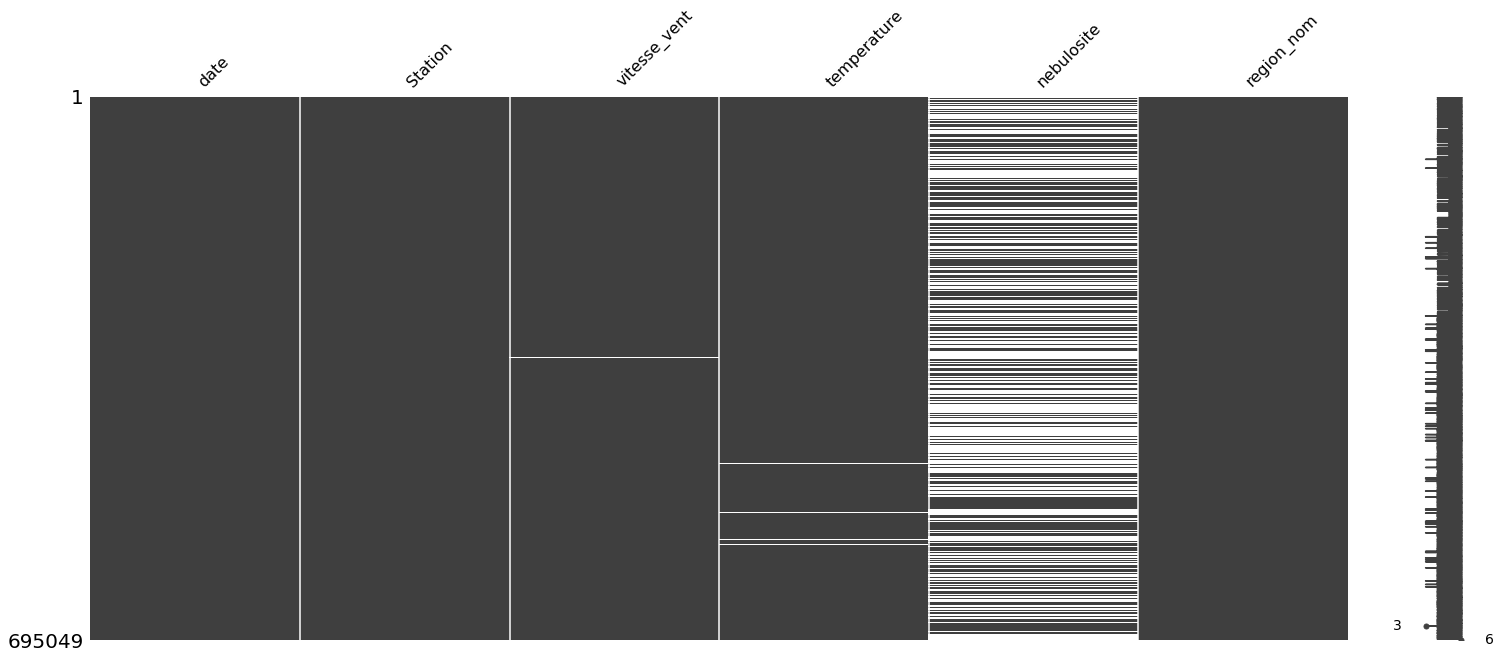

In [26]:
# Visualisation des NANs
msno.matrix(df_meteo);

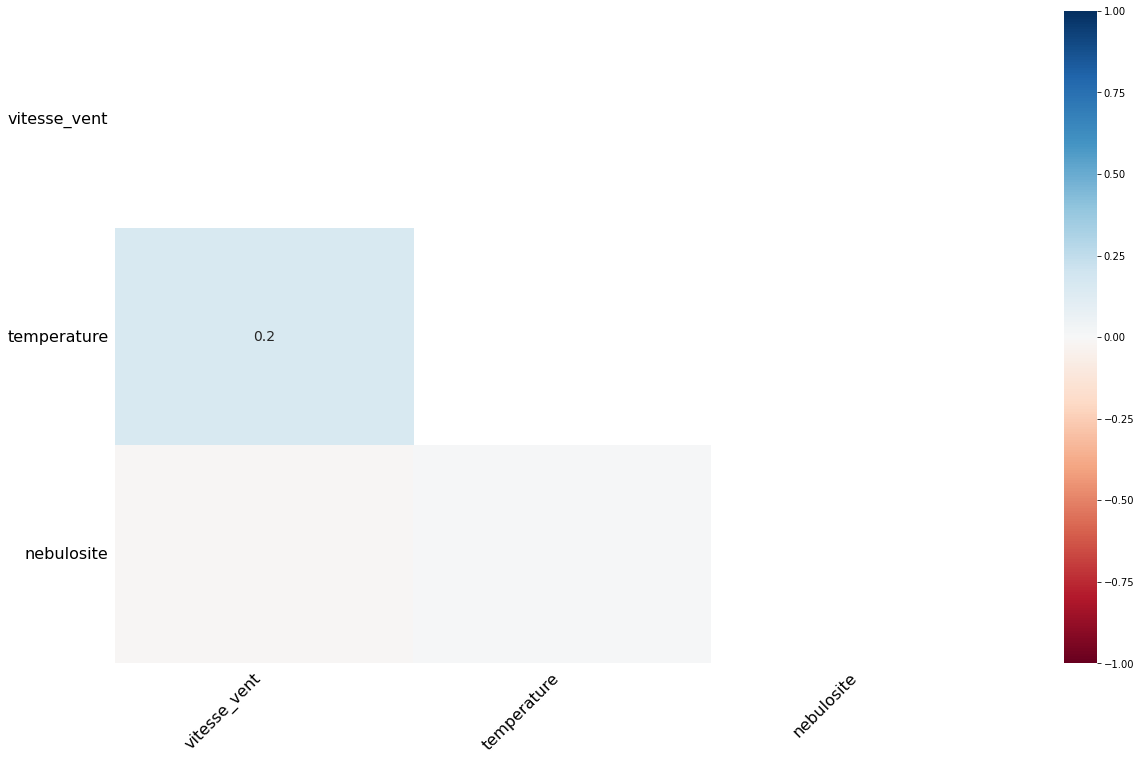

In [28]:
msno.heatmap(df_meteo);

### 1.4.5 Restructuration du DF météo

In [29]:
df_meteo.isna().sum(axis = 0)

date                 0
Station              0
vitesse_vent      2115
temperature       6484
nebulosite      328055
region_nom           0
dtype: int64

In [30]:
len(df_meteo['date'])

695049

In [31]:
# Group by en conservant le niveau de détail des stations
df_meteo = df_meteo.groupby( ['date','region_nom','Station']).agg({
    'vitesse_vent' : 'mean', 
    'temperature'  : 'mean', 
    'nebulosite'   : 'mean' 
})

# Tri des valeurs
#df_meteo = df_meteo.sort_values(by=['region_nom'],axis=0, ascending=True, na_position='last')

In [32]:
df_meteo.isna().sum(axis = 0)

vitesse_vent      2115
temperature       6484
nebulosite      328054
dtype: int64

In [33]:
df_meteo = df_meteo.interpolate()
df_meteo.isna().sum(axis = 0)

vitesse_vent    0
temperature     0
nebulosite      1
dtype: int64

In [34]:
df_meteo['nebulosite'] = df_meteo['nebulosite'].fillna(100)

In [35]:
df_meteo.head(5)

vitesse_vent  \
date                      region_nom              Station                 
2016-01-01 00:00:00+00:00 Auvergne-Rhône-Alpes    7460              0.8   
                                                  7471              0.5   
                                                  7481              0.0   
                                                  7577              1.2   
                          Bourgogne-Franche-Comté 7280              0.8   

                                                           temperature  \
date                      region_nom              Station                
2016-01-01 00:00:00+00:00 Auvergne-Rhône-Alpes    7460             1.8   
                                                  7471             4.1   
                                                  7481             7.7   
                                                  7577             8.8   
                          Bourgogne-Franche-Comté 7280             5.6   

                                                           nebulosite  
date                      region_nom              Station              
2016-01-01 00:00:00+00:00 Auvergne-Rhône-Alpes    7460          100.0  
                                                  7471          100.0  
                                                  7481          100.0  
                                                  7577          100.5  
                          Bourgogne-Franche-Comté 7280          101.0

In [36]:
# Group by en supprimant le niveau de détail des stations
df_meteo = df_meteo.groupby( ['date','region_nom']).agg({
    'vitesse_vent' : 'mean', 
    'temperature'  : 'mean', 
    'nebulosite'   : 'mean' 
})

In [38]:
len(df_meteo['temperature'])

209978

In [39]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 209978 entries, (Timestamp('2016-01-01 00:00:00+0000', tz='UTC'), 'Auvergne-Rhône-Alpes') to (Timestamp('2021-12-31 00:00:00+0000', tz='UTC'), 'Île-de-France')
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vitesse_vent  209978 non-null  float64
 1   temperature   209978 non-null  float64
 2   nebulosite    209978 non-null  float64
dtypes: float64(3)
memory usage: 5.5+ MB


In [153]:
# Fusion du nouveau DF avec le DF meteo, avec un jointure gauche (donc sur le nouveau DF)
df_meteo = dateregion.merge(df_meteo, 
                            how='left', 
                            left_on=['date', 'region_nom'], 
                            right_on=['date', 'region_nom'])

df_meteo.reset_index(inplace=True)

In [40]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 209978 entries, (Timestamp('2016-01-01 00:00:00+0000', tz='UTC'), 'Auvergne-Rhône-Alpes') to (Timestamp('2021-12-31 00:00:00+0000', tz='UTC'), 'Île-de-France')
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vitesse_vent  209978 non-null  float64
 1   temperature   209978 non-null  float64
 2   nebulosite    209978 non-null  float64
dtypes: float64(3)
memory usage: 5.5+ MB


In [41]:
df_meteo.isna().sum(axis = 0)

vitesse_vent    0
temperature     0
nebulosite      0
dtype: int64

In [42]:
# Le DF doit être trié par région puis par date
df_meteo.head()

vitesse_vent  temperature  \
date                      region_nom                                           
2016-01-01 00:00:00+00:00 Auvergne-Rhône-Alpes            0.625         5.60   
                          Bourgogne-Franche-Comté         0.800         5.60   
                          Bretagne                        2.275         5.80   
                          Centre-Val de Loire             2.600         4.90   
                          Grand Est                       2.000         4.64   

                                                   nebulosite  
date                      region_nom                           
2016-01-01 00:00:00+00:00 Auvergne-Rhône-Alpes        100.125  
                          Bourgogne-Franche-Comté     101.000  
                          Bretagne                     75.500  
                          Centre-Val de Loire          56.250  
                          Grand Est                    90.500

In [43]:
# le DF est complété

df_meteo.loc[:, ['vitesse_vent', 'temperature','nebulosite']].fillna(method='pad', inplace=True)

In [44]:
df_meteo.isna().sum(axis = 0)

vitesse_vent    0
temperature     0
nebulosite      0
dtype: int64

## 1.5 Fusion des deux DataSet

### 1.5.1 Merge

In [55]:
# jointure des deux dataset

df = df_energie.merge(df_meteo, 
                      how='left', 
                      left_on=['date', 'region_nom'], 
                      right_on=['date', 'region_nom'])




In [58]:
#Suppression des deux précédents DF pour libérer de la mémoire
del df_energie 
del df_meteo

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115645 entries, 0 to 1115644
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype              
---  ------              --------------    -----              
 0   region_nom          1115645 non-null  object             
 1   nature              1115645 non-null  object             
 2   date                1115645 non-null  datetime64[ns, UTC]
 3   conso_inter         1115645 non-null  float64            
 4   prod_therm          1115645 non-null  float64            
 5   prod_nuc            1115645 non-null  float64            
 6   prod_eol            1115645 non-null  float64            
 7   prod_sol            1115645 non-null  float64            
 8   prod_hydro          1115645 non-null  float64            
 9   conso_hydro         1115645 non-null  float64            
 10  prod_bio            1115645 non-null  float64            
 11  echanges            1115645 non-null  float64            
 12  

### 1.5.2 Complétude (NANs)

In [56]:
df.isna().sum(axis = 0)

date                  0
region_nom            0
nature              168
conso_inter         168
prod_therm          168
prod_nuc         420812
prod_eol            168
prod_sol            168
prod_hydro          168
conso_hydro      525973
prod_bio            168
echanges            168
tco_therm        841632
tch_therm        841632
tco_nuc          981788
tch_nuc          981788
tco_eol          841632
tch_eol          841632
tco_sol          841632
tch_sol          841632
tco_hydro        841632
tch_hydro        841632
tco_bio          841632
tch_bio          841632
vitesse_vent    1052130
temperature     1052130
nebulosite      1052130
dtype: int64

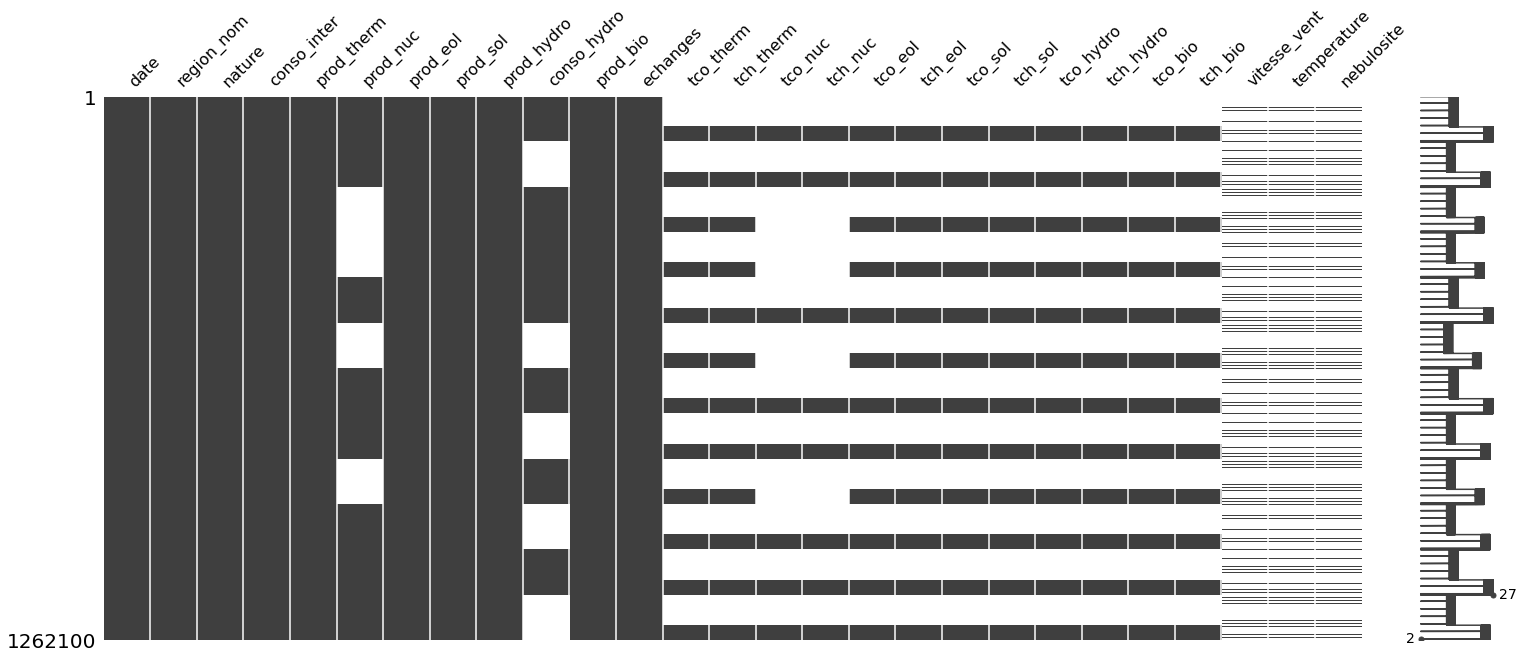

In [59]:
# Visualisation des NANs
msno.matrix(df);

In [ ]:




# Traitement des NANs des variables quantitatives

df_meteo['temperature']        = df_meteo['temperature'].fillna(60)        #Remplacement par une valeur distinctive pour permettre de faire des graphes

#df_meteo['temperature']        = df_meteo['temperature'].fillna(method='pad')        #Remplacement par la valeur précédente
df_meteo['vitesse_vent_10min'] = df_meteo['vitesse_vent_10min'].fillna(method='pad') #Remplacement par la valeur précédente
df_meteo['nebulosite_totale']  = df_meteo['nebulosite_totale'].fillna(method='pad')  #Remplacement par la valeur précédente

#df_meteo['temperature']        = df_meteo['temperature'].fillna(df_meteo['temperature'].mean())
#df_meteo['vitesse_vent_10min'] = df_meteo['vitesse_vent_10min'].fillna(df_meteo['vitesse_vent_10min'].mean())
#df_meteo['nebulosite_totale']  = df_meteo['nebulosite_totale'].fillna(df_meteo['nebulosite_totale'].mean())

# Partie 2 : Exploration et Story-telling <a class="anchor" id="Partie02"><a>

## 2.1 Exploration sur la consommation d'energie

## 2.2 Exploration sur les sources de productions

## 2.3 Relations Consommation & Production

## 2.4 Relations consommation & Météo

# Partie 3 : Problématique et analyse <a class="anchor" id="Partie03"><a>

## 3.1 Définition de la problématique

## 3.2 Construction d'indicateurs

## 3.3 Données pour Dashboard PowerBI

## 3.4 Prédictions

# Partie 4 : Conclusions  <a class="anchor" id="Partie04"><a>

## 4.1 Apports du projet en réponse à la problématique

## 4.2 Limites et axes d'amélioration